## Q - learning

#### Autores:
- Celia Quiles Aleman - 202315604@alu.comillas.edu
 - Álvaro Ezquerro Pérez - alvaroezquerro@alu.comillas.edu
 - María Calvo de Mora Román - 202320059@alu.comillas.edu

#### Desarrollado por:
María Calvo de Mora Román

En este notebook, vamos a desarrollar un agente que utiliza Q-learning para aprender a jugar en el entorno discreto de Blackjack. A continuación se detallan las especificaciones del entorno que nuestro agente enfrentará, basadas en la documentación proporcionada.

##### Acciones:

El espacio de acción en el entorno de Blackjack incluye dos posibles acciones:
- **Pegar (Hit, acción=1)**: El jugador solicita otra carta para intentar acercarse más a un total de 21 sin pasarse.
- **Quedarse (Stand, acción=0)**: El jugador decide no recibir más cartas, terminando su turno.


##### Estado:

El agente observa el estado del juego a través de una tupla que contiene:
- La suma actual de las cartas del jugador.
- El valor de la carta visible del crupier (1-10, donde 1 es un as).
- Un indicador de si el jugador tiene un as utilizable (0 o 1).

##### Recompensas:
Las recompensas se asignan como sigue:
- Ganar la partida: +1
- Perder la partida: -1
- Empate: 0
- Ganar con un blackjack natural:
    - +1.5 si la opción 'natural' está activada y se gana con un blackjack natural.
    - +1 si la opción 'natural' está desactivada o no se gana con un blackjack natural.
El objetivo es maximizar la suma total de recompensas, lo que implica gestionar de manera efectiva el riesgo y la oportunidad de tomar cartas adicionales para acercarse a un total de 21.

##### Terminación del Episodio:
El episodio termina cuando el jugador se pasa de 21 (bust), después de que el jugador se queda y el crupier juega su mano, o cuando el jugador obtiene un blackjack natural, dependiendo de las reglas específicas configuradas en el entorno.

Utilizaremos la versión 'Blackjack-v1' del entorno, que está diseñada para reflejar la versión del juego de blackjack descrita en el libro "Reinforcement Learning: An Introduction" por Sutton y Barto. Además, emplearemos las opciones por defecto del entorno es decir con la opción 'natural' desactivada.

#### Importación de librerías

In [1]:
import gym
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from src.utils.plotting import plot_blackjack_performance
import pickle

#### Creación del entorno

In [2]:
# Definir el entorno
env = gym.make('Blackjack-v1', natural=False)

# Información del entorno
print("Action Space {}". format(env.action_space))
print("State Space {}.". format(env.observation_space))

Action Space Discrete(2)
State Space Tuple(Discrete(32), Discrete(11), Discrete(2)).


Se observa como, tal y como se ha comentado antes, hay 2 posibles acciones y el espacio de estados es discreto de modo que el agente observa el estado del juego a través de una tupla que contiene 3 elementos (suma cartas, carta visible crupier y existencia de as utilizable)

#### Entrenamiento de un agente aleatorio que sirva como base

Incialmente, se procede a realizar una búsqueda de la solución a la fuerza bruta sin utilizar ningún algoritmo. Para ello, se procede a crear un agente que realice acciones totalmente aleatorias, de modo que nos pueda servir como base a la hora de comparar el rendimiento de los algoritmos probados.

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\mcalv\anaconda3\envs\ML2-DL\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 100/100 [00:00<00:00, 6885.28it/s]


Recompensa media: -0.43, Duración media episodios: 1.35


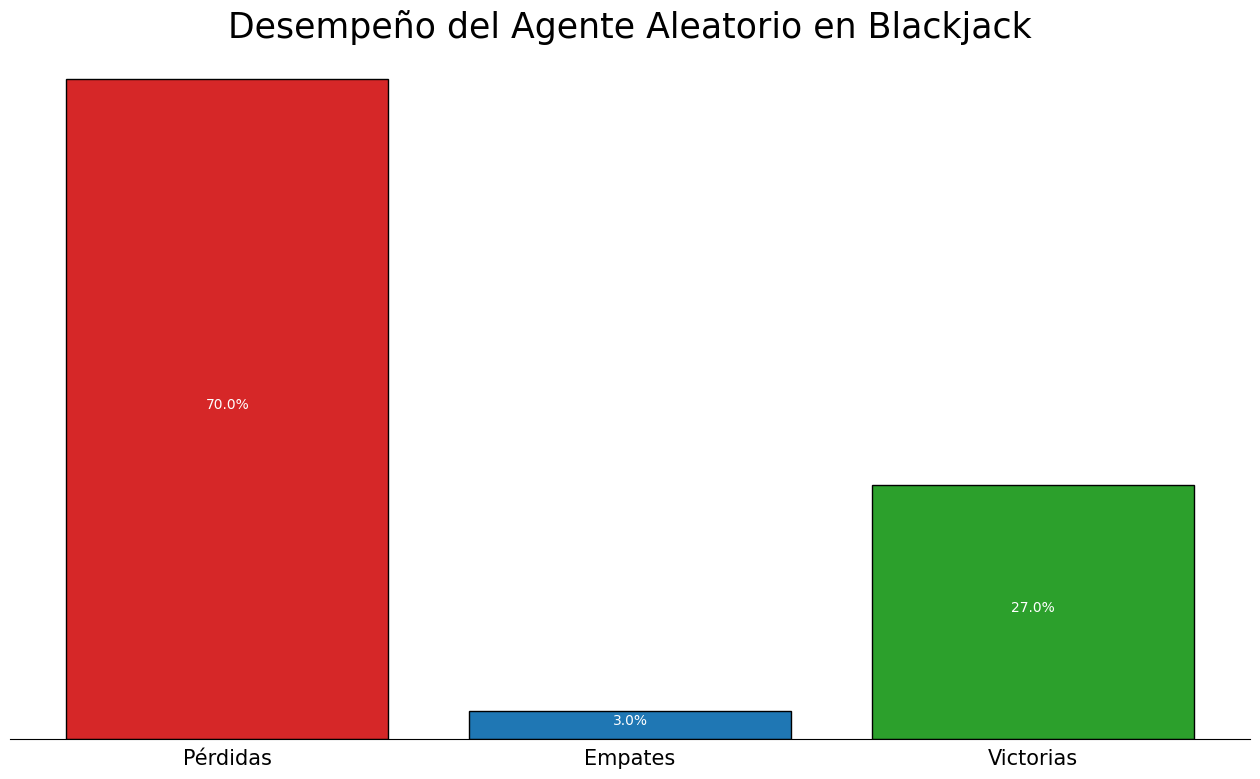

In [3]:
def run_episode_random(env):
    """ Funcion que ejecuta un episodio en el entorno
    Args:
        env: entorno de OpenAI Gym
        Returns:
        total_reward: recompensa total obtenida en el episodio
        penalties: numero de penalizaciones (veces que se ha perdido)
        epochs: numero de pasos ejecutados en el episodio
    """
    state = env.reset()
    done = False
    total_reward = 0
    steps = 0
    
    while not done:
        action = env.action_space.sample()  # Elige una acción aleatoria
        state, reward, done, truncate, info = env.step(action)
        total_reward += reward
        steps += 1
    
    return total_reward, steps

def evaluate_random_agent(env, num_episodes=1000):
    total_rewards = []
    total_steps = 0

    for _ in tqdm(range(num_episodes)):
        episode_reward, episode_steps = run_episode_random(env)
        total_rewards.append(episode_reward) 
        total_steps += episode_steps

    avg_reward = sum(total_rewards) / num_episodes
    avg_episode_length = total_steps / num_episodes

    return avg_reward, avg_episode_length, total_rewards

# Example usage:
avg_reward, avg_episode_length, total_rewards= evaluate_random_agent(env, num_episodes=100)
print(f"Recompensa media: {avg_reward}, Duración media episodios: {avg_episode_length}")
plot_blackjack_performance(total_rewards, "Desempeño del Agente Aleatorio en Blackjack")

In [5]:
def evaluate_agent(env, n_episodes):
    """ Funcion que evalua un agente en un entorno
    Args:
        env: entorno de OpenAI Gym
        n_episodes: numero de episodios a ejecutar
    Returns:
        win_rate: Tasa de victorias del agente.
        total_rewards: Recompensa total alcanzada en el entrenamiento.
        total_penalties: Penalización total alcanzada en el entrenamiento.
        total_steps: Número total de pasos alcanzados durante el entrenamiento.
    """
    rewards = []
    penalties = []
    steps = []
    result = []

    for _ in tqdm(range(n_episodes)):
        episode_reward, episode_penalties, episode_steps = run_episode_random(env)
        rewards.append(episode_reward)
        penalties.append(episode_penalties)
        steps.append(episode_steps)
        if episode_reward > 0: 
            result.append(1)
        else:
            result.append(0)
    
    data = {'Victorias': result, 'Recompensas': rewards, 'Penalizaciones': penalties, 'Pasos': steps}
    results_df = pd.DataFrame(data=data)
    
    return results_df

In [6]:
def plot_results(results_df, title):
    """ Función que muestra los resultados obtenidos en forma de gráfico de barras.
    Args:
        results_df: DF de resultados de cada episodio.
        title: Título del gráfico.
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    categories = ['Tasa de Victorias', 'Recompensas Totales', 'Penalizaciones Totales', 'Pasos Totales']

    win_rate = results_df["Victorias"].mean()
    total_rewards = results_df['Recompensas'].sum()
    total_penalties = results_df['Penalizaciones'].sum()
    total_steps = results_df['Pasos'].sum()

    print(win_rate, total_rewards, total_penalties, total_steps)

    values = [win_rate, total_rewards, total_penalties, total_steps]
    colors = ['gold', 'blue', 'red', 'green']
    bars = ax.bar(categories, values, color=colors)
    
    ax.set_ylabel('Valores')
    ax.set_title(title)
    
    for bar in bars:
        yval = bar.get_height()
        position = yval - 0.05 if yval < 0 else yval + 0.05
        ax.text(bar.get_x() + bar.get_width()/2.0, position, round(yval, 2), va='center', ha='center')
    
    plt.tight_layout()
    plt.show()

In [7]:
def plot_results_for_episode(results_df, title):
    """ Función que muestra los resultados obtenidos en forma de gráfico de barras.
    Args:
        results_df: DF de resultados de cada episodio.
        title: Título del gráfico.
    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    colors = ['gold', 'blue', 'red', 'green']

    for i, col in enumerate(results_df.columns):
        ax = axs[i // 2, i % 2]
        ax.plot(results_df.index, results_df[col], color=colors[i])
        ax.set_title(col)
    
    plt.tight_layout()
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\mcalv\anaconda3\envs\ML2-DL\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 1000/1000 [00:00<00:00, 10118.07it/s]


0.285 -394.0 679 1375


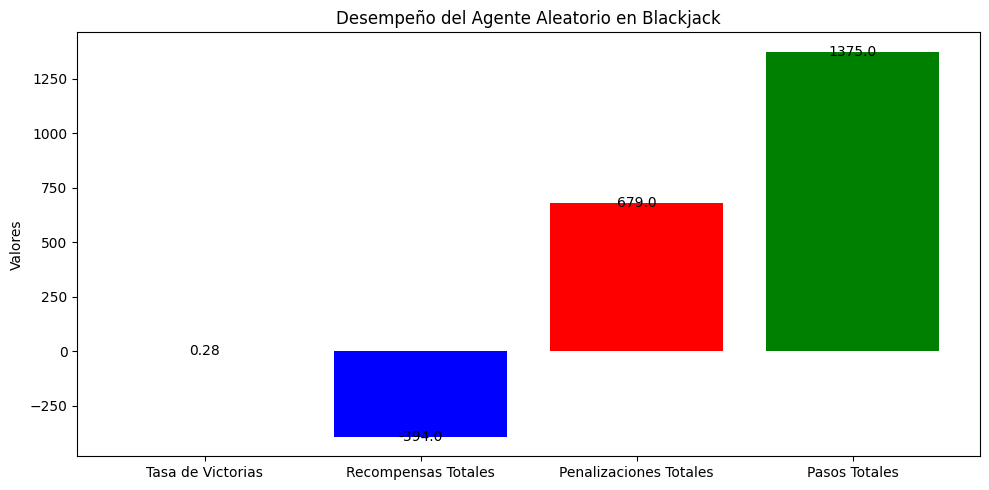

In [8]:
# Evaluar el agente
results_df = evaluate_agent(env, 1000)

title = 'Desempeño del Agente Aleatorio en Blackjack'
plot_results(results_df, title)

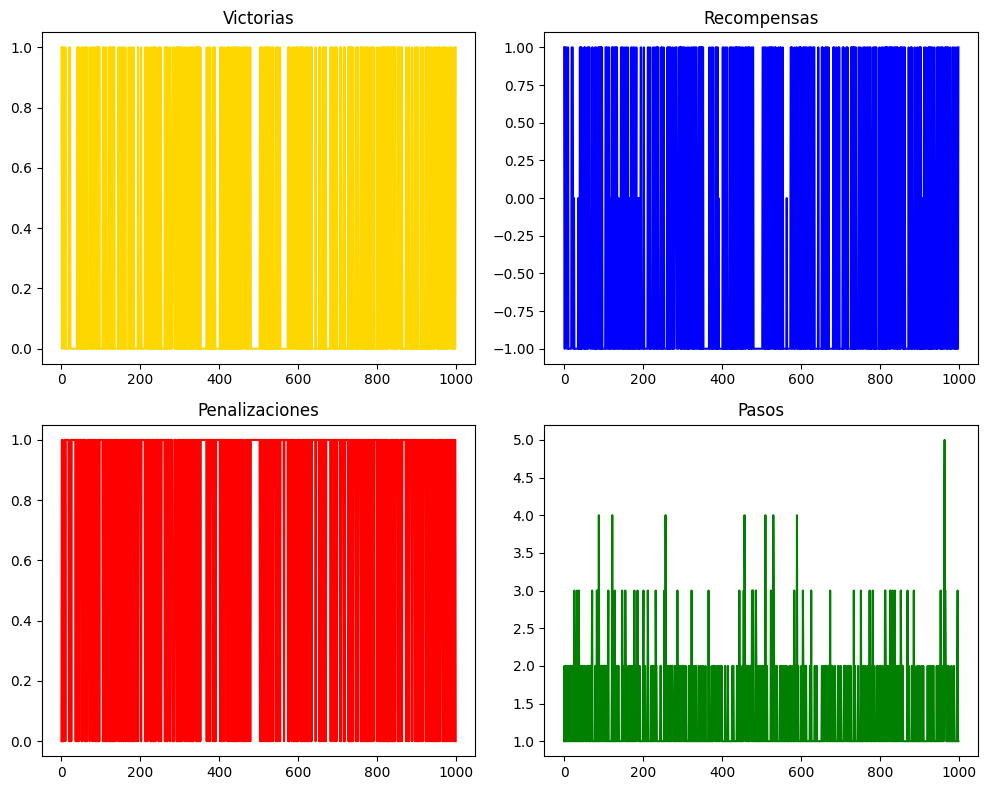

In [9]:
plot_results_for_episode(results_df, title)

In [10]:
env.close()

#### Entrenamiento con Q-learning

In [12]:
# Hiperparámetros
alpha = 0.1
gamma = 0.6
epsilon = 0.1  # Política epsilon-greedy (10% de exploración)

In [13]:
# Entorno
env = gym.make('Blackjack-v1', natural=False)

# Inicializar la tabla Q
state_space = env.observation_space
action_space = env.action_space

rng = np.random.default_rng(2024)
q_table = defaultdict(lambda: rng.uniform(low=-0.001, high=0.001, size=(2,)))

In [11]:
def choose_action(state, rng):
    """
    Función que elige una acción para un estado dado
    
    Args:
        state: estado actual
    Returns:
        action: acción elegida
    """
    if rng is not None and rng.random() < epsilon:
        return action_space.sample()  # Explorar: elegir una acción aleatoria
    else:
        return np.argmax(q_table[state])  # Explotar: elegir la mejor acción conocida

In [ ]:
def update_q_table(state, action, reward, next_state):
    """
    Función que actualiza la tabla Q
    
    Args:
        state: estado actual
        action: acción realizada
        reward: recompensa obtenida
        next_state: siguiente estado
    """
    old_value = q_table[state][action]
    next_max = np.max(q_table[next_state])
    new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
    q_table[state][action] = new_value

In [16]:
def train_agent(episodes):
    """
    Función que entrena un agente en un entorno
    
    Args:
        episodes: número de episodios a ejecutar
    """
    for episode in tqdm(range(episodes)):
        state = env.reset()
        state = state[0]
        done = False
        
        while not done:
            action = choose_action(state, rng)
            next_state, reward, done, truncate, info = env.step(action) 
            update_q_table(state, action, reward, next_state)
            state = next_state
            

In [17]:
def evaluate_Q_agent(episodes):
    """
    Función que evalúa un agente entrenado en un entorno.
    
    Args:
        episodes: número de episodios a ejecutar.
    Returns:
        win_rate: tasa de victorias del agente.
        total_rewards: recompensa total obtenida.
        total_penalties: número total de penalizaciones.
        total_steps: número total de pasos ejecutados.
    """
    rewards = []
    penalties = []
    steps = []
    result = []
    
    for _ in tqdm(range(episodes)):
        state = env.reset()
        state = state[0]
        epochs, _reward, _penalties, win = 0, 0, 0, 0
        done = False
        
        while not done:
            action = np.argmax(q_table[state])
            next_state, reward, done, truncate, info = env.step(action)
            state = next_state 
            epochs += 1
            _reward += reward
            
            if reward == -1:
                _penalties += 1
            elif reward > 0:
                win = 1

        result.append(win)
        rewards.append(_reward)
        penalties.append(_penalties)
        steps.append(epochs)
    
    data = {'Victorias': result, 'Recompensas': rewards, 'Penalizaciones': penalties, 'Pasos': steps}
    results_df = pd.DataFrame(data=data)
    
    return results_df


In [19]:
# Entrenar el agente
N = 100_000
train_agent(N)
env.close()

# Guardar la tabla Q en un archivo
with open(f'src/models/q_table_{N}.pkl', 'wb') as f:
    pickle.dump(dict(q_table), f)


100%|██████████| 100000/100000 [00:10<00:00, 9796.66it/s]


In [15]:
render = False  # Si quieremos mostrar la evaluación o no (si es True, se recomienda un bajo episodio de evaluación)

# Entorno
if render:
    env = gym.make('Blackjack-v1', render_mode="human")
else:
    env = gym.make('Blackjack-v1')

N=100000
# Cargar la tabla Q desde un archivo pickle
with open(f'src/models/q_table_{N}.pkl', 'rb') as f:
    q_table = pickle.load(f)

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\mcalv\anaconda3\envs\ML2-DL\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 1000/1000 [00:00<00:00, 11553.44it/s]

Recompensa media: -0.161, Duración media episodios: 1.688


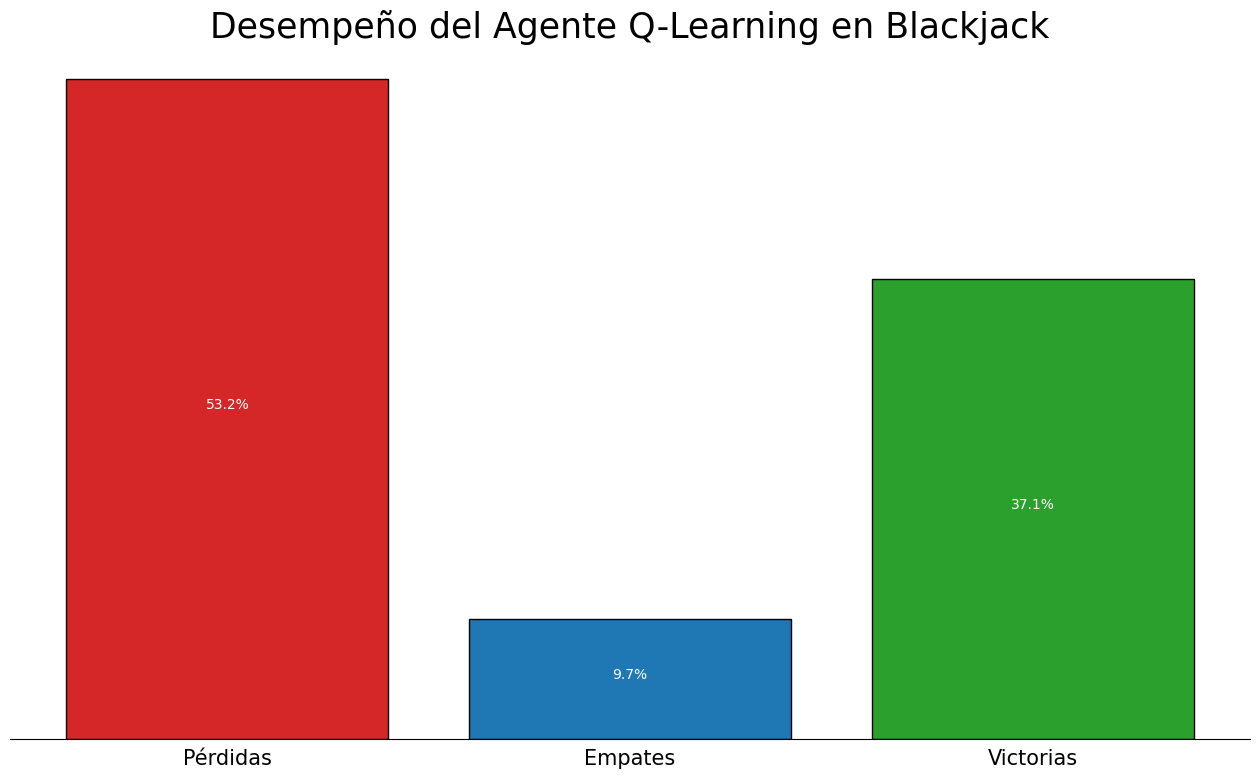

In [23]:
def run_episode_qlearning(env):
    """
    Funcion que ejecuta un episodio en el entorno
    
    Args:
        env: entorno de OpenAI Gym
        Returns:
        total_reward: recompensa total obtenida en el episodio
        penalties: numero de penalizaciones (veces que se ha perdido)
        epochs: numero de pasos ejecutados en el episodio
    """
    state, _ = env.reset()
    done = False
    total_reward = 0
    steps = 0
    
    while not done:
        action = choose_action(state, None)
        state, reward, done, truncate, info = env.step(action)
        total_reward += reward
        steps += 1
    
    return total_reward, steps

def evaluate_qlearning_agent(env, num_episodes=1000):
    total_rewards = []
    total_steps = 0

    for _ in tqdm(range(num_episodes)):
        episode_reward, episode_steps = run_episode_qlearning(env)
        total_rewards.append(episode_reward) 
        total_steps += episode_steps

    avg_reward = sum(total_rewards) / num_episodes
    avg_episode_length = total_steps / num_episodes

    return avg_reward, avg_episode_length, total_rewards

# Example usage:
avg_reward, avg_episode_length, total_rewards= evaluate_qlearning_agent(env, num_episodes=1000)
print(f"Recompensa media: {avg_reward}, Duración media episodios: {avg_episode_length}")
plot_blackjack_performance(total_rewards, "Desempeño del Agente Q-Learning en Blackjack")


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\mcalv\anaconda3\envs\ML2-DL\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Q Table:
(20, 8, False)  ->  [ 2.20662255 -0.98262223]
(8, 8, False)  ->  [-0.25372898  0.26603474]
(12, 10, False)  ->  [-0.75388703 -0.55659281]
(21, 10, False)  ->  [ 2.21900835 -0.99982627]
(21, 3, True)  ->  [2.41571599 0.32071623]
(15, 3, False)  ->  [-0.61252505 -0.61102841]
(18, 1, False)  ->  [-0.50464589 -0.66398866]
(15, 1, False)  ->  [-1.03285065 -0.64696612]
(25, 1, False)  ->  [-0.00094449  0.00072041]
(9, 1, False)  ->  [-0.88612733 -0.25184195]
(13, 4, False)  ->  [-0.46943011 -0.22269802]
(11, 9, False)  ->  [-0.09614472  0.71395207]
(8, 10, False)  ->  [-0.89549725 -0.22094955]
(18, 10, False)  ->  [-0.89272452 -0.53338934]
(28, 10, False)  ->  [9.22731230e-05 6.38826867e-04]
(15, 5, False)  ->  [-0.6045378  -0.50025939]
(25, 5, False)  ->  [0.00064293 0.00064732]
(16, 7, True)  ->  [-0.45863355  0.2378638 ]
(10, 10, False)  ->  [-0.16303603 -0.0920485 ]
(15, 8, False)  ->  [-0.73490192 -0.39112735]
(9, 5, False)  ->  [-0.02432775  0.15058172]
(16, 5, False)  ->  [-0

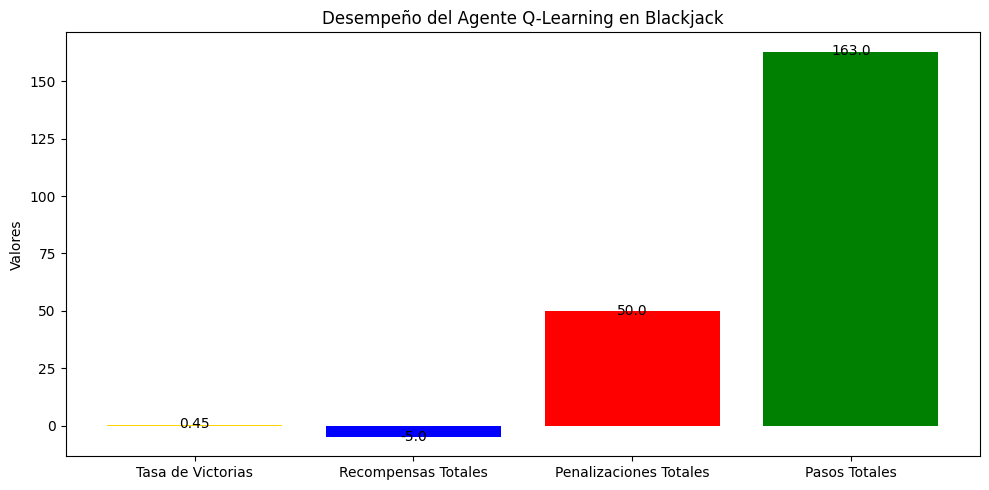

In [21]:
# Evaluar el agente entrenado
results_df = evaluate_Q_agent(100)
# Imprimir la tabla Q
print("Q Table:")
for key, value in q_table.items():
    print(key, " -> ", value) 
title = 'Desempeño del Agente Q-Learning en Blackjack'
plot_results(results_df, title)
plot_results_for_episode(results_df, title)
env.close()